# Summary

We're interested in GitHub project health. I first establish a baseline
using known successful projects and projects which were previously successful
but have now been retired. This notebook is intended to get the basic working
thing together then we can scale up later.

# Objective function:

Lines of code is a good indicator but we don't want to 
just reward increasing project complexity. I want to
equally reward code additions and deletions so we'll
use the [Manhattan Norm](https://en.wikipedia.org/wiki/Taxicab_geometry)
or $l_1$ distance.

$$
||x||_1 := \sum_{i=1}^n |x_i|.
$$

We want to maximize the $l_1$ distance so we can define
the cost function $c(x)$ as

$$
c(x) = -\sum_{i=1}^n |x_i|
$$

which means we want to now minimize $c(x)$.


## Dependencies

In [504]:
from collections import defaultdict
import os
from urllib.parse import urljoin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from okra.models import (Meta, Author, Contrib, CommitFile, Info)
from okra.models import DataAccessLayer
from okra.playbooks import local_persistance
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sqlalchemy import func

%matplotlib inline

## Prepare Data

In [2]:
DATA = "/Users/tylerbrown/code/"
repos = [
    "torvalds/linux",
    "docker/docker-ce",
    'apache/attic-lucy',
    'apache/attic-wink',
    'apache/spark',
    'apache/lucene-solr'
]

In [3]:
# Persist repo info in database

for repo_name in repos:
    local_persistance(repo_name, DATA)

Issue with row 0, repo '/Users/tylerbrown/code/torvalds/linux'
Issue with row 0, repo '/Users/tylerbrown/code/docker/docker-ce'
Issue with row 0, repo '/Users/tylerbrown/code/apache/attic-lucy'
Issue with row 0, repo '/Users/tylerbrown/code/apache/attic-wink'
Issue with row 0, repo '/Users/tylerbrown/code/apache/spark'
Issue with row 0, repo '/Users/tylerbrown/code/apache/lucene-solr'


In [4]:
repodbs = {i : i.replace("/", "__REPODB__") + ".db" for i in repos}
repodbs

{'torvalds/linux': 'torvalds__REPODB__linux.db',
 'docker/docker-ce': 'docker__REPODB__docker-ce.db',
 'apache/attic-lucy': 'apache__REPODB__attic-lucy.db',
 'apache/attic-wink': 'apache__REPODB__attic-wink.db',
 'apache/spark': 'apache__REPODB__spark.db',
 'apache/lucene-solr': 'apache__REPODB__lucene-solr.db'}

# Exploratory Analysis: Linux Kernel

Trying to get an idea of which features would be informative
by exploring the Linux kernel. Some initial thoughts about
repo health indicators

1. Number of commits per time period
1. Number of developers per time period


In [5]:
conn_string = "sqlite:///" + urljoin(DATA, repodbs['torvalds/linux'])

In [6]:
dal = DataAccessLayer(conn_string)
dal.connect()
dal.session = dal.Session()

### Compute objective function per month

Let's start by computing our objective function
once per month. 

In [7]:
q1 = dal.session.query(
    Meta.commit_hash, Author.authored, CommitFile.lines_added, CommitFile.lines_deleted
).join(Author).join(CommitFile)

In [8]:
items = []
for item in q1.all():
    r = {
        "commit_hash": item.commit_hash,
        "date_authored": item.authored,
        "lines_added": item.lines_added,
        "lines_deleted": item.lines_deleted
    }
    items.append(r)
objdf = pd.DataFrame(items)
objdf.shape

(1824726, 4)

In [9]:
per = objdf.date_authored.dt.to_period("M")

In [10]:
ok = objdf.groupby(per).sum()

In [11]:
ok['costfunc'] = -np.sqrt(np.square(ok.lines_added.values) + np.square(ok.lines_deleted.values))

In [12]:
ok.head()

,lines_added,lines_deleted,costfunc
date_authored,,,
1970-01,2,1,-2.236068
2001-09,145,48,-152.738338
2002-04,2272,632,-2358.263768
2003-02,56,55,-78.492038
2004-07,9,0,-9.000000


### Check features against cost function

In [13]:
# Number of commits per time period
q2 = dal.session.query(
    Meta.commit_hash, Info.created
).join(Info)

items = []
for item in q2.all():
    r = {
        "commit_hash" : item.commit_hash,
        "date_created" : item.created,
    }
    items.append(r)
comdf = pd.DataFrame(items)

In [14]:
per = comdf.date_created.dt.to_period('M')
comdf.shape

(824976, 2)

In [15]:
comct = comdf.groupby(per).count()

In [16]:
comct.head()

,commit_hash,date_created
date_created,,
1970-01,1,1
2001-09,2,2
2002-04,12,12
2003-02,1,1
2004-07,1,1


In [17]:
# Number of developers per time period

q3 = dal.session.query(
    Meta.commit_hash, Author.name, Author.email, 
    Author.authored
).join(Author)

items = []
for item in q3.all():
    r = {
        "commit_hash": item.commit_hash,
        "author_name": item.name,
        "author_email": item.email,
        "author_date": item.authored,
    }
    items.append(r)
authordf = pd.DataFrame(items)

In [18]:
authordf.shape

(824976, 4)

In [19]:
per = authordf.author_date.dt.to_period('M')

In [20]:
authct = authordf[['author_name','author_email']].groupby(per).count()

In [21]:
authct.head()

,author_name,author_email
author_date,,
1970-01,1,1
2001-09,2,2
2002-04,12,12
2003-02,1,1
2004-07,1,1


## Initial predictive model

In [22]:
print("y: {}, commits: {}, author: {}".format(ok.shape, comct.shape, authct.shape))

y: (183, 3), commits: (183, 2), author: (183, 2)


In [23]:
df = ok.join(comct).join(authct)

In [24]:
df.head()

,lines_added,lines_deleted,costfunc,commit_hash,date_created,author_name,author_email
date_authored,,,,,,,
1970-01,2,1,-2.236068,1,1,1,1
2001-09,145,48,-152.738338,2,2,2,2
2002-04,2272,632,-2358.263768,12,12,12,12
2003-02,56,55,-78.492038,1,1,1,1
2004-07,9,0,-9.000000,1,1,1,1


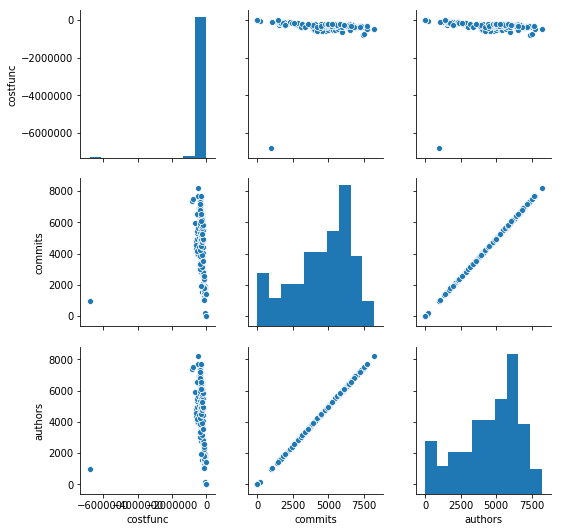

In [25]:
data = df[['costfunc', 'commit_hash', 'author_name']]
data.columns = ['costfunc', 'commits', 'authors']
sns.pairplot(data)
plt.show()

In [26]:
data.describe()

,costfunc,commits,authors
count,1.830000e+02,183.000000,183.000000
mean,-3.225717e+05,4508.065574,4508.065574
std,5.021419e+05,2119.350172,2119.350172
min,-6.794630e+06,1.000000,1.000000
25%,-3.615016e+05,3166.000000,3166.000000
50%,-2.895008e+05,4962.000000,4962.000000
75%,-2.200318e+05,6169.500000,6169.500000
max,-1.414214e+00,8202.000000,8202.000000


It looks like `commits` and `authors` are almost perfectly correlated
so there's no reason to use both features. There also appears to be
an instance of a strong outlier in the `costfunc`. Let's try to predict
using a Ridge Regression and one feature. 

In [27]:
data_dropoutliers = data[data.costfunc > -500000]

In [28]:
data.shape

(183, 3)

In [29]:
data_dropoutliers.shape

(167, 3)

In [30]:
data_dropoutliers.describe()

,costfunc,commits,authors
count,167.000000,167.000000,167.000000
mean,-260558.345094,4443.161677,4443.161677
std,116334.779914,2158.053243,2158.053243
min,-491590.509291,1.000000,1.000000
25%,-337389.687224,3077.500000,3077.500000
50%,-284437.946317,4962.000000,4962.000000
75%,-210811.308781,6169.500000,6169.500000
max,-1.414214,8202.000000,8202.000000


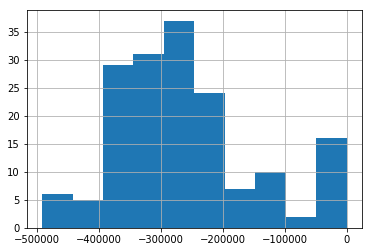

In [31]:
data_dropoutliers.costfunc.hist()

In [32]:
X = data_dropoutliers.authors
y = data_dropoutliers.costfunc

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
X_train.shape

(133,)

In [35]:
X_train = np.reshape(X_train.values, (-1, 1))
y_train = np.reshape(y_train.values, (-1, 1))

In [36]:
X_test = np.reshape(X_test.values, (-1, 1))
y_test = np.reshape(y_test.values, (-1, 1))

In [37]:
# Ridge regression

reg01 = linear_model.RidgeCV(alphas=[10.0, 100.0, 1000.0], cv=3)

In [38]:
reg01.fit(X_train, y_train)

/Users/tylerbrown/miniconda3/envs/ds6050/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([  10.,  100., 1000.]), cv=3, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [39]:
reg01.score(X_test, y_test)

0.6917690156769369

In [40]:
y_pred = reg01.predict(y_test)

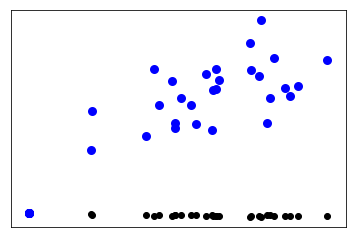

In [41]:
plt.scatter(X_test, y_test, color='black')
plt.scatter(X_test, y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

In [42]:
reg02 = linear_model.LinearRegression()

In [43]:
reg02.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [44]:
reg02.score(X_test, y_test)

0.6917693547603874

In [45]:
y_pred = reg02.predict(y_test)

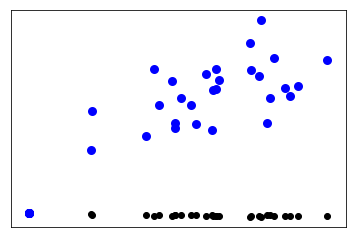

In [46]:
plt.scatter(X_test, y_test, color='black')
plt.scatter(X_test, y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

In [47]:
reg1 = DecisionTreeRegressor(max_depth=2)
reg2 = DecisionTreeRegressor(max_depth=5)
reg3 = DecisionTreeRegressor(max_depth=10)

In [48]:
reg1.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [49]:
y_01 = reg01.predict(X_test)
y_02 = reg02.predict(X_test)
y_1 = reg1.predict(X_test)
y_2 = reg2.predict(X_test)
y_3 = reg3.predict(X_test)

In [50]:
reg01.score(X_test, y_test)

0.6917690156769369

In [51]:
reg02.score(X_test, y_test)

0.6917693547603874

In [52]:
reg1.score(X_test, y_test)

0.7654731622213409

In [53]:
reg2.score(X_test, y_test)

0.7027919990278851

In [54]:
reg3.score(X_test, y_test)

0.6121575273331039

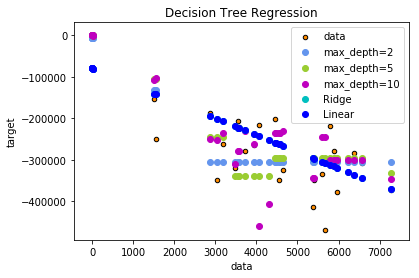

In [55]:
# Plot the results
plt.figure()
plt.scatter(X_test, y_test, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.scatter(X_test, y_1, color="cornflowerblue",
         label="max_depth=2")
plt.scatter(X_test, y_2, color="yellowgreen", label="max_depth=5")
plt.scatter(X_test, y_3, color='m', label='max_depth=10')
plt.scatter(X_test, y_01, color='c', label='Ridge')
plt.scatter(X_test, y_02, color='b', label='Linear')
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

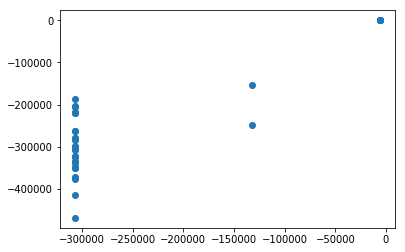

In [56]:
plt.scatter(np.reshape(y_1, (-1,1)), y_test)

## Better time series approach

Those models performed kind of terribly. Let's see
if we can dig more into the time series and do something
better.

In [57]:
data.shape

(183, 3)

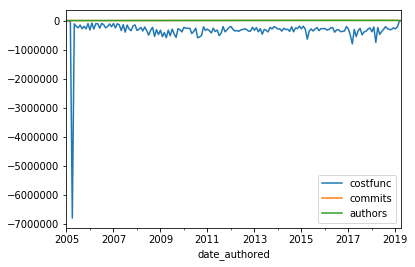

In [58]:
data[(data.index >= '2005-01') & (data.index < '2020-01')].plot()
plt.show()

We can see that there really isn't a clear relationship between commits,
authors, and lines of code added or subtracted. This explains why the 
previous models weren't performing well.

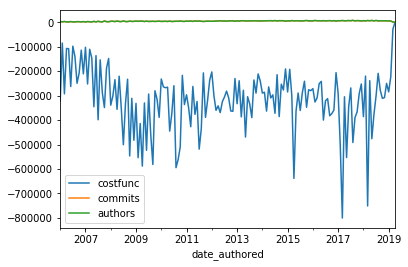

In [59]:
data[(data.index >= '2006-01') & (data.index < '2020-01')].plot()
plt.show()

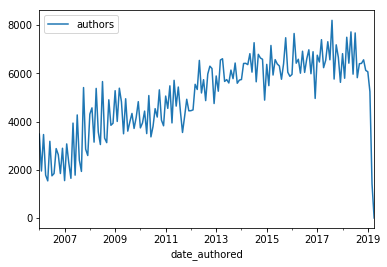

In [60]:
data[(data.index >= '2006-01') & (data.index < '2020-01')][['authors']].plot()
plt.show()

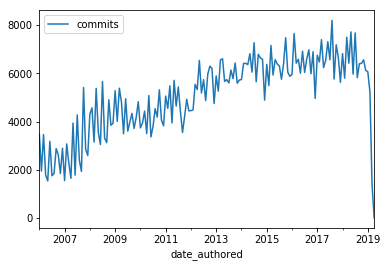

In [61]:
data[(data.index >= '2006-01') & (data.index < '2020-01')][['commits']].plot()
plt.show()

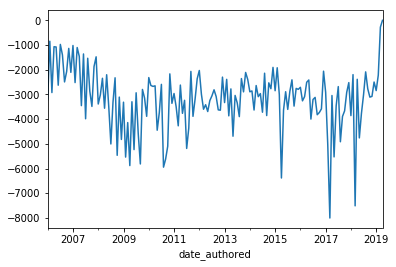

In [62]:
(data[(data.index >= '2006-01') & (data.index < '2020-01')].costfunc / 100).plot()

In [63]:
data['norm_cost'] = data.costfunc / 100
data['norm_authors'] = -data.authors
data['norm_commits'] = -data.commits

/Users/tylerbrown/miniconda3/envs/ds6050/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tylerbrown/miniconda3/envs/ds6050/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tylerbrown/miniconda3/envs/ds6050/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

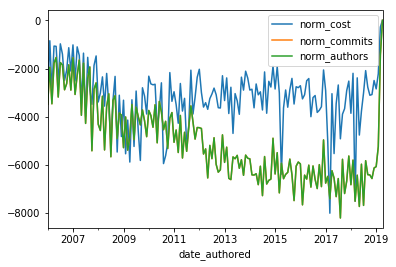

In [64]:

data[(data.index >= '2006-01') & (data.index < '2020-01')][['norm_cost','norm_commits','norm_authors']].plot()
plt.show()

# Rethinking approach

This experience is making me rethink how we are approaching problems in Data Science. 
Trying to predict an aggregate effect seems like it's problematic and very difficult 
to extract causal mechanisms. 

Some of the work in AI which use known differential equations to include known laws
from physics, then estimate certain parts of those equations seems interesting. My
approach has been reasoning about a system without taking any of the known constraints
into consideration. Some constraints to consider:

1. Difficulty of multiple authors working on the same file at one time
1. Difficulty of working with files containing large numbers of commits
1. Difficulty of any developer contributing large amounts of code at
   one time.
1. Difficulty of new developers making large contributions to an established
   project.

I'm going to try a different approach that tries to establish some of these constraints,
then predict at a lower level of aggregation. If this is successful, then we can establish
the following relationship:

* $k_p = \text{$\max$ number of additions or deletions to a project at time $t$}$
* $k_l = \text{$\max$ number of additions or deletions to a file at time $t$}$
* $k_d = \text{$\max$ number of developers to a file at time $t$}$
* $k_f = \text{$\max$ number of files per project at time $t$}$

Given these maximum values $k$ at time $t$, I expect the following relationships

$$
k_p \approx \frac{k_lk_d}{k_f}
$$

We should then see the lead developer $d^\star$try to approximate $k$ which reflects them, $d^\star$,
trying to maximize the value of the project $p$. Let's see if this theory is supported by the 
Linux kernel data.

In [65]:
# t should be for each day

q4 = dal.session.query(
    Meta.commit_hash, Author.authored, CommitFile.modified_file,
    CommitFile.lines_added, CommitFile.lines_deleted
).join(Author).join(CommitFile)

items = []
for item in q4.all():
    r = {
        "commit_hash": item.commit_hash,
        "date_authored": item.authored,
        "modified_file": item.modified_file,
        "lines_added": item.lines_added,
        "lines_deleted": item.lines_deleted,
    }
    items.append(r)
fildf = pd.DataFrame(items)
print(fildf.shape)


(1824726, 5)


In [66]:
per = fildf.date_authored.dt.to_period("D")
day = fildf.groupby([per, 'modified_file']).sum()
day['costfunc'] = -np.sqrt(np.square(day.lines_added.values) + np.square(day.lines_deleted.values))
day['total_lines'] = day.lines_added + day.lines_deleted
day.shape

(1309841, 4)

In [67]:
day.head()

lines_added  lines_deleted  \
date_authored modified_file                                                  
1970-01-01    drivers/s390/net/qeth_main.c                2              1   
2001-09-17    drivers/staging/usbip/vhci_hcd.c            2              2   
              drivers/usb/core/hub.c                     65              8   
              drivers/usb/dwc3/ep0.c                      4              0   
              drivers/usb/gadget/dummy_hcd.c              2              2   

                                                 costfunc  total_lines  
date_authored modified_file                                             
1970-01-01    drivers/s390/net/qeth_main.c      -2.236068            3  
2001-09-17    drivers/staging/usbip/vhci_hcd.c  -2.828427            4  
              drivers/usb/core/hub.c           -65.490457           73  
              drivers/usb/dwc3/ep0.c            -4.000000            4  
              drivers/usb/gadget/dummy_hcd.c    -2.828427            4

In [68]:
day.describe()

,lines_added,lines_deleted,costfunc,total_lines
count,1.309841e+06,1.309841e+06,1.309841e+06,1.309841e+06
mean,3.939487e+01,1.921675e+01,-5.283569e+01,5.861162e+01
std,2.975361e+02,1.638906e+02,3.384043e+02,3.565748e+02
min,0.000000e+00,0.000000e+00,-1.338840e+05,0.000000e+00
25%,1.000000e+00,0.000000e+00,-2.280351e+01,2.000000e+00
50%,3.000000e+00,2.000000e+00,-5.830952e+00,7.000000e+00
75%,1.400000e+01,7.000000e+00,-2.000000e+00,2.700000e+01
max,1.338840e+05,4.229900e+04,-0.000000e+00,1.338840e+05


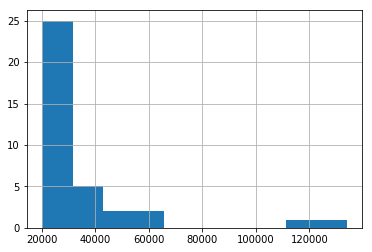

In [77]:
day[day.total_lines > 20000].total_lines.hist()
plt.show()

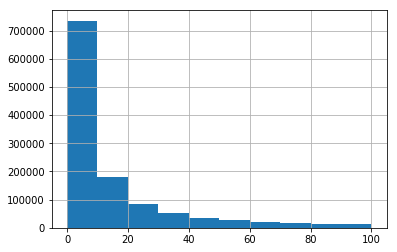

In [82]:
day[day.total_lines <= 100].total_lines.hist()
plt.show()

In [91]:
(day.total_lines <= 10).sum() / day.shape[0]

0.5845778228044473

In [92]:
((day.total_lines > 10) & (day.total_lines <= 100)).sum() / day.shape[0]

0.3136502827442415

In [93]:
(day.total_lines > 100).sum() / day.shape[0]

0.10177189445131127

In [94]:
# let's do this by author per file now

q5 = dal.session.query(
    Meta.commit_hash, Author.authored, Author.name, Author.email,
    CommitFile.lines_added, CommitFile.lines_deleted
).join(Author).join(CommitFile)

items = []
for item in q5.all():
    r = {
        "commit_hash": item.commit_hash,
        "date_authored": item.authored,
        "author_name": item.name,
        "author_email": item.email,
        "lines_added": item.lines_added,
        "lines_deleted": item.lines_deleted,
    }
    items.append(r)
autdf = pd.DataFrame(items)
print(autdf.shape)

(1824726, 6)


In [95]:
per = autdf.date_authored.dt.to_period("D")

In [96]:
dayauth = autdf.groupby([per, 'author_name','author_email']).sum()

In [98]:
dayauth['total_lines'] = dayauth.lines_added + dayauth.lines_deleted
print(dayauth.shape)
dayauth.head()

(317713, 3)


,,,lines_added,lines_deleted,total_lines
date_authored,author_name,author_email,,,
1970-01-01,Ursula Braun,braunu@de.ibm.com,2,1,3
2001-09-17,John Youn,John.Youn@synopsys.com,145,48,193
2002-04-09,Greg Kroah-Hartman,gregkh@suse.de,2272,632,2904
2003-02-20,Ayaz Abdulla,aabdulla@nvidia.com,56,55,111
2004-07-29,Greg Edwards,edwardsg@sgi.com,9,0,9


In [99]:
dayauth.describe()

,lines_added,lines_deleted,total_lines
count,3.177130e+05,317713.000000,3.177130e+05
mean,1.624139e+02,79.225238,2.416392e+02
std,1.203170e+04,1298.719543,1.211895e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,3.000000e+00,1.000000,6.000000e+00
50%,1.300000e+01,5.000000,2.200000e+01
75%,5.800000e+01,25.000000,9.600000e+01
max,6.718755e+06,219905.000000,6.718755e+06


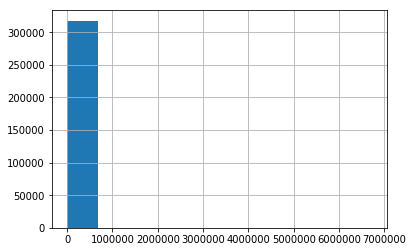

In [100]:
dayauth.total_lines.hist()
plt.show()

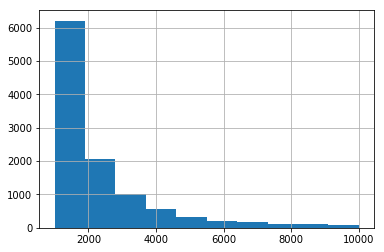

In [108]:
dayauth[(dayauth.total_lines >= 1000) & (dayauth.total_lines < 10000)].total_lines.hist()
plt.show()

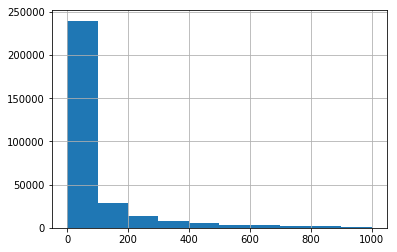

In [110]:
dayauth[(dayauth.total_lines < 1000)].total_lines.hist()
plt.show()

# More thoughts

It looks like trying to find a maximum value $k$ for lines of code changed, and number of developers,
is way too high. Working at the file at time $t = day$ seems better than using the aggregate. We have
indivdual contributors moving the needle too much. Let's try look at this as more of a physics problem.

Let's just try to do some things with Velocity

$$
v = \frac{d}{t}
$$

where $d$ is lines added or deleted from a file per day as time $t$. Let's compute

$$
v_{file}
$$

In [159]:
# file velocity

per = autdf.date_authored.dt.to_period('D')
autdf['total_lines'] = autdf.lines_added + autdf.lines_deleted

In [160]:
velday = autdf[['date_authored','total_lines']].groupby(per).sum()

In [161]:
velday.shape

(5192, 1)

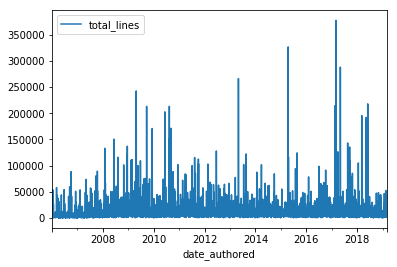

In [162]:
velday[(velday.index > '2006-01') & (velday.index <= '2019-03')].plot()
plt.show()

In [185]:
velautday = autdf[['date_authored','author_name']].groupby([per]).count()
velautday.shape

(5192, 2)

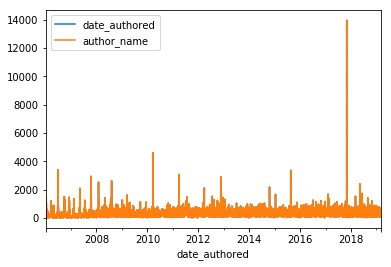

In [186]:
velautday[(velautday.index > '2006-01') & (velautday.index <= '2019-03')].plot()
plt.show()

In [187]:
autdf.head()

,author_email,author_name,commit_hash,date_authored,lines_added,lines_deleted,total_lines
0,torvalds@linux-foundation.org,Linus Torvalds,8c2ffd9174779014c3fe1f96d9dc3641d9175f00,2019-03-24 14:02:26,1,1,2
1,shc_work@mail.ru,Alexander Shiyan,2a6a8e2d9004b5303fcb494588ba3a3b87a256c3,2018-12-20 14:16:26,13,32,45
2,darrick.wong@oracle.com,Darrick J. Wong,18915b5873f07e5030e6fb108a050fa7c71c59fb,2019-03-23 12:10:29,7,0,7
3,yi.zhang@huawei.com,zhangyi (F),5e86bdda41534e17621d5a071b294943cae4376e,2019-03-23 11:56:01,22,25,47
4,yi.zhang@huawei.com,zhangyi (F),674a2b27234d1b7afcb0a9162e81b2e53aeef217,2019-03-23 11:43:05,8,4,12


In [171]:
# author velocity (forget the number of files for now)

per = autdf.date_authored.dt.to_period('D')
authvel = autdf[['author_name','date_authored','total_lines']].groupby([per, 'author_name']).sum()

In [172]:
authvel.head()

,,total_lines
date_authored,author_name,
1970-01-01,Ursula Braun,3
2001-09-17,John Youn,193
2002-04-09,Greg Kroah-Hartman,2904
2003-02-20,Ayaz Abdulla,111
2004-07-29,Greg Edwards,9


In [173]:
authvel.sort_values(by='total_lines', ascending=False).head()

,,total_lines
date_authored,author_name,
2005-04-16,Linus Torvalds,6718755
2017-03-02,Alex Deucher,367999
2015-04-16,Alex Deucher,314489
2017-05-04,Alex Deucher,277280
2013-05-02,Peng Tao,258994


In [204]:
linus_contribs = autdf[autdf.author_name == 'Linus Torvalds'][['date_authored', 'total_lines']].groupby(per).sum()

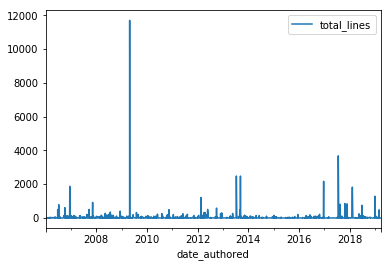

In [213]:
linus_contribs[linus_contribs.index > '2006-01'].plot()
plt.show()

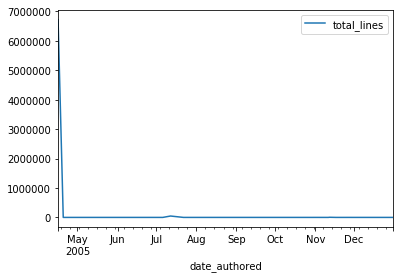

In [215]:
linus_contribs[linus_contribs.index <= '2006-01'].plot()
plt.show()

In [216]:
alex_contribs = autdf[autdf.author_name =='Alex Deucher'][['date_authored', 'total_lines']].groupby(per).sum()

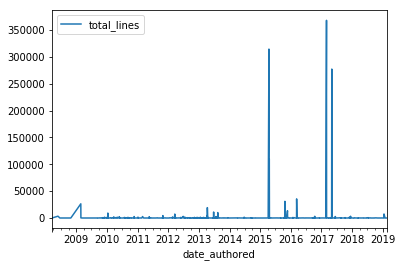

In [218]:
alex_contribs.plot()
plt.show()

In [219]:
alex_contribs.describe()

,total_lines
count,1175.000000
mean,1218.683404
std,16657.886138
min,1.000000
25%,8.000000
50%,36.000000
75%,132.000000
max,367999.000000


In [220]:
alex_contribs.shape

(1175, 1)

In [222]:
alex_contribs.shape[0] / velday.shape[0]

0.22630970724191063

In [223]:
linus_contribs.shape[0] / velday.shape[0]

0.2723420647149461

In [312]:
autdf.author_name.describe()

count                1824726
unique                 20010
top       Greg Kroah-Hartman
freq                   33051
Name: author_name, dtype: object

In [232]:
days_contributed = autdf['date_authored'].groupby(per).unique().shape

In [236]:
dailies = autdf[['author_name','date_authored']].groupby([per, 'author_name'])

In [254]:
daily_part = dailies.size().reset_index().groupby('author_name')['date_authored'].count()

In [257]:
daily = pd.DataFrame(daily_part)

In [261]:
daily.columns = ['days_contributed']
daily.head()

,days_contributed
author_name,
,10
=?UTF-8?q?Christian=20K=C3=B6nig?=,2
=?UTF-8?q?Simon=20Sandstr=C3=B6m?=,1
=?utf-8?q?Felix_K=C3=BChling?=,1
=?utf-8?q?Michel_D=C3=A4nzer?=,5


In [262]:
daily['percent_total'] = daily.days_contributed / days_contributed

In [265]:
daily.sort_values(by='percent_total', ascending=False).head()

,days_contributed,percent_total
author_name,,
Takashi Iwai,1832,0.352851
Eric Dumazet,1633,0.314522
David S. Miller,1492,0.287365
Johannes Berg,1442,0.277735
Linus Torvalds,1414,0.272342


## Thoughts so far

Alright, it looks like contributions are really spikey because even the
top authors are only contributing code about 30% of the days where code
could be contributed. Let's get a better understanding of how often top
authors are actually contributing by setting them up against a proper 
range of dates.

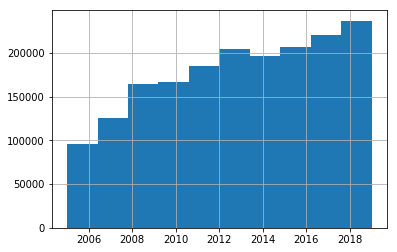

In [274]:
autdf[(autdf.date_authored >= '2005-01') & (autdf.date_authored < '2019-01')].date_authored.hist()

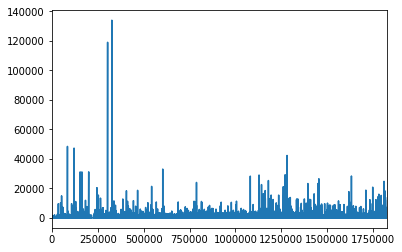

In [283]:
autdf[(autdf.date_authored >= '2005-01') & (autdf.date_authored < '2019-01')].total_lines.plot()

In [349]:
linux_dates = pd.DataFrame(pd.date_range('2005-01', '2019-01'))
linux_dates.columns = ['date_range']
linux_dates.head()

,date_range
0,2005-01-01
1,2005-01-02
2,2005-01-03
3,2005-01-04
4,2005-01-05


In [350]:
linux_dates = linux_dates.groupby(per).count()
linux_dates.shape

(117, 1)

In [351]:
autbyday = autdf[['author_email','author_name','date_authored', 'lines_added', 
                  'lines_deleted', 'total_lines']].groupby([per,'author_name']).sum()

In [352]:
autbyday.head()

,,lines_added,lines_deleted,total_lines
date_authored,author_name,,,
1970-01-01,Ursula Braun,2,1,3
2001-09-17,John Youn,145,48,193
2002-04-09,Greg Kroah-Hartman,2272,632,2904
2003-02-20,Ayaz Abdulla,56,55,111
2004-07-29,Greg Edwards,9,0,9


In [353]:
autbyday.shape

(314906, 3)

In [361]:
items = pd.merge(linux_dates, autbyday, left_index=True, right_on='date_authored')

In [373]:
autdf.date_authored.describe()

count                 1824726
unique                 730276
top       2005-04-16 15:20:36
freq                    17291
first     1970-01-01 01:00:01
last      2037-04-25 10:08:26
Name: date_authored, dtype: object

In [386]:
items = autdf[['author_name', 'lines_added','lines_deleted', 'total_lines']].groupby(per).sum()

In [387]:
items.shape

(5192, 3)

In [388]:
items.head()

,lines_added,lines_deleted,total_lines
date_authored,,,
1970-01-01,2,1,3
2001-09-17,145,48,193
2002-04-09,2272,632,2904
2003-02-20,56,55,111
2004-07-29,9,0,9


In [389]:
linux_dates.shape

(117, 1)

In [390]:
linux_dates.head()

,date_range
date_authored,
2017-12-14,5
2018-04-04,19
2018-07-02,1
2018-08-23,1
2018-10-10,2


In [399]:
linux_windows = pd.merge(linux_dates, items, left_index=True, right_index=True, how='outer')

## Joining on dates

It looks like joining on dates to get a full date range doesn't really work in pandas.
Let's write our own functions to sort this out.

In [419]:
dates = pd.DataFrame(pd.date_range('2005-01', '2019-01', freq='D'))
dates.columns = ['dates']

In [420]:
dates.head()

,dates
0,2005-01-01
1,2005-01-02
2,2005-01-03
3,2005-01-04
4,2005-01-05


In [421]:
dates.shape

(5114, 1)

In [422]:
autdf.shape

(1824726, 7)

In [426]:
autdict = autdf.to_dict()

In [433]:
autdf.head()

,author_email,author_name,commit_hash,date_authored,lines_added,lines_deleted,total_lines
0,torvalds@linux-foundation.org,Linus Torvalds,8c2ffd9174779014c3fe1f96d9dc3641d9175f00,2019-03-24 14:02:26,1,1,2
1,shc_work@mail.ru,Alexander Shiyan,2a6a8e2d9004b5303fcb494588ba3a3b87a256c3,2018-12-20 14:16:26,13,32,45
2,darrick.wong@oracle.com,Darrick J. Wong,18915b5873f07e5030e6fb108a050fa7c71c59fb,2019-03-23 12:10:29,7,0,7
3,yi.zhang@huawei.com,zhangyi (F),5e86bdda41534e17621d5a071b294943cae4376e,2019-03-23 11:56:01,22,25,47
4,yi.zhang@huawei.com,zhangyi (F),674a2b27234d1b7afcb0a9162e81b2e53aeef217,2019-03-23 11:43:05,8,4,12


In [444]:
autdict['date_authored'][0]

Timestamp('2019-03-24 14:02:26')

In [446]:
datedict = dates.to_dict()['dates']

In [494]:
def date_transform(datedict):
    these = {}
    for key in datedict.keys():
        item = datedict[key]
        new_key = str(item.year) + '-' + str(item.dayofyear)
        these[new_key] = item
    return these

def author_transform(autdict):
    items = defaultdict(list)
    for idx in range(len(autdict['commit_hash'])):
        
        new_key = str(autdict['date_authored'].year) + '-' + str(autdict['date_authored'].dayofyear)
        new_item = (autdict['author_email'], autdict['author_name'], autdict['commit_hash'],\
                    autdict['date_authored'], autdict['lines_added'], autdict['lines_deleted'],\
                    autdict['total_lines'])
        items[new_key].append(new_item)
        
    return items

def date_join(autht, datet):
    
    rows = []
    r = {
        'date_key': np.NaN,
        'author_email': np.NaN,
        'author_name': np.NaN,
        'commit_hash': np.NaN,
        'date_authored': np.NaN,
        'lines_added': np.NaN,
        'lines_deleted': np.NaN,
        'total_lines': np.NaN,
    } 

    for date_key in datet.keys():
        
        if date_key in autht:
            
            for i in autht[date_key]:
                
                rd = r.copy()
                
                
    

Timestamp('2005-01-01 00:00:00')

In [456]:
datedict[0].year

2005

In [503]:
autdict.keys()

dict_keys(['author_email', 'author_name', 'commit_hash', 'date_authored', 'lines_added', 'lines_deleted', 'total_lines'])

In [486]:
POSSIBLE_TOTAL = len(datedict.keys())**2

In [491]:
def rework_datastructure():
    pass

def full_dates(date_range, autdf):
    row = {
        'author_email': np.NaN,
        'author_name': np.NaN,
        'commit_hash': np.NaN,
        'date_authored': np.NaN,
        'lines_added': np.NaN,
        'lines_deleted': np.NaN,
        'total_lines': np.NaN,
    }
    
    found = []
    count = 0
    for date_key in date_range.keys():
        
        prow = row.copy()
        matched = False
        for idx, aut_date in enumerate(autdf['date_authored']):
            
            if date_range[date_key].year == autdf['date_authored'][aut_date].year and \
            date_range[date_key].dayofyear == autdf['date_authored'][aut_date].dayofyear:
                prow = row.copy()  
                prow['author_email'] = autdf['author_email'][idx]
                prow['author_name'] = autdf['author_name'][idx]
                prow['commit_hash'] = autdf['commit_hash'][idx]
                prow['date_authored'] = autdf['date_authored'][idx]
                prow['lines_added'] = autdf['lines_added'][idx] 
                prow['lines_deleted'] = autdf['lines_deleted'][idx]
                prow['total_lines'] = autdf['total_lines'][idx]
                
                found.append(prow)
                matched = True
                
        if not matched:
            prow = row.copy()
            prow['date_authored'] = date_range[date_key]
            prow['lines_added'] = 0
            prow['lines_deleted'] = 0
            prow['total_lines'] = 0
            found.append(prow)
        
        matched = False
        
        if count % 10000 == 0:
            print("processed {} records".format(count))
        count += 1
        
    return prow
        
        
        

In [492]:
len(datedict)

5114

In [489]:
df = full_dates(datedict, autdict)

processed 0 records


KeyboardInterrupt: 

In [ ]:
df.to_pickle("full_dates.pkl")